In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
import json
from torchvision import datasets, transforms
import tqdm
import os


In [2]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [3]:
batch_size = 64
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 0.1 # априорная дисперсия
epoch_num = 25 #количество эпох
lamb = [0.1, 1,  10, 100]
hidden_num = 100 #количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5


lam_hidden_num = 50
lambda_sample_num = 5
path_to_save = 'saved'


In [4]:
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)


In [6]:
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_, device=device)) # параметры средних
        t.nn.init.xavier_uniform(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_, device = device)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_, device=device)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_, device=device) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  t.exp(self.log_sigma_b))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    

In [7]:
class LowRankNet(nn.Module):
    def __init__(self, size, hidden, gain_const = 1.0, gain_lamb = 1.0, gain_const2 = 0.000001,
                 gain_lowrank = .0001,  act= F.relu):    
        nn.Module.__init__(self)        
        self.w = nn.Linear(1, hidden).to(device)
        t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
        # проверка на вектор или матрица
        if isinstance(size, tuple) and len(size) == 2: # если сайз неизменяемый список и его длина 2
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1,device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            self.w_d = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform_(self.w_d.weight, gain_lowrank)
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 

            
        else:
            self.w_a1 = nn.Linear(hidden, self.in_).to(device)
            t.nn.init.xavier_uniform_(self.w_a1.weight, gain_lowrank)
            
            self.w_a2 = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform_(self.w_a2.weight, gain_lowrank)
            
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform_(self.const,  gain_const)
            
        
            
            
    def forward(self, lam):
        h = self.act(self.w(self.one * lam))        
        if self.diagonal:
            return self.const + self.w_d(h)
        else:
            a1 = self.w_a1(h)
            a2 = self.w_a2(h)
         
            return self.const +  t.matmul(a1.view(-1, 1), a2.view(1, -1)) 

        
class LinearApprNet(nn.Module):
    def __init__(self, size,  gain_const = 1.0, gain_const2 = 0.000001,  act= lambda x: x):    
        nn.Module.__init__(self)        
        if isinstance(size, tuple) and len(size) == 2:
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1, device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            self.const2 = nn.Parameter(t.ones(self.out_, device=device) * gain_const2) 
            
            
        else:
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform_(self.const,  gain_const)
            self.const2 = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform_(self.const2,  gain_const2)
            
            
    def forward(self, lam):        
        if self.diagonal:
            return self.const + self.const2 * lam
        else:
            return self.const + self.const2 * lam 

        
class VarLayerLowRank(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LowRankNet((in_, out_), lam_hidden_num) # параметры средних            
        self.log_sigma = LowRankNet((in_, out_), lam_hidden_num) # логарифм дисперсии
        self.mean_b = LowRankNet( out_, lam_hidden_num) # то же самое для свободного коэффициента
        self.log_sigma_b = LowRankNet( out_, lam_hidden_num)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    

class VarLayerLinearAppr(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LinearApprNet((in_, out_)) # параметры средних            
        self.log_sigma = LinearApprNet((in_, out_)) # логарифм дисперсии
        self.mean_b = LinearApprNet( out_) # то же самое для свободного коэффициента
        self.log_sigma_b = LinearApprNet( out_)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self, x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2    

In [8]:
class VarSeqNet(nn.Sequential):    
    # класс-обертка на случай, если у нас многослойная нейронная сеть
    def KLD(self, lam = None):
        k = 0
        for l in self: 
            if lam is None:
                k+=l.KLD()
            else:
                k+=l.KLD(lam)
                
        return k
    
    def forward(self, x, lam = None):
        if lam is None:
            for l in self:
                x = l(x)
            return x
        else:
            for l in self:
                x = l(x, lam)
            return x
    


In [9]:
def train_batches(net, loss_fn, optimizer, lam, label):
    tq = tqdm.tqdm(train_loader)
    losses = []
    for x,y in tq:            
        x = x.to(device)
        y = y.to(device)          
        optimizer.zero_grad()  
        loss = 0
        if lam is None:
            for _ in range(lambda_sample_num):  
                p = t.rand(1).to(device)*3 -1
                lam_param = 10**p[0]
                
                #t.rand(1).to(device)[0]*100.0                  
                out = net(x, t.log(lam_param))
                loss = loss + loss_fn(out, y)/lambda_sample_num
                loss += net.KLD(lam_param)*(lam_param)/len(train_data)/lambda_sample_num
                losses+=[loss.cpu().detach().numpy()]
            # правдоподобие должно суммироваться по всей обучающей выборке
            # в случае батчей - она приводится к тому же порядку 
        else:
            out = net(x)
            loss = loss + loss_fn(out, y)
            loss += net.KLD()*lam/len(train_data)
            losses+=[loss.cpu().detach().numpy()]
        tq.set_description(label+str(np.mean(losses)))
        loss.backward()       
        clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
        optimizer.step()

In [41]:
t.manual_seed(0)
for lam in lamb:
    for start in range(start_num):                    
            net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                train_batches(net, loss_fn, optim, lam, label)
            t.save(net.state_dict(), os.path.join(path_to_save, 'var_net_lam_{}_start_{}.cpk'.format(lam, start)))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
lambda 1, epoch 19: 0.46120715: 100%|██████████| 938/938 [00:13<00:00, 72.13it/s]


lambda 100, epoch 18: 2.3091426: 100%|██████████| 938/938 [00:13<00:00, 68.61it/s]


lambda 100, epoch 24: 2.3118727: 100%|██████████| 938/938 [00:14<00:00, 65.19it/s]


In [22]:
for mode in ['linear']:
    t.manual_seed(0)
    for start in range(start_num): 
        if mode == 'lowrank':
            net = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
        else:
            net = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
            
        net = net.to(device)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        for e in range(epoch_num):
            label = '{}, epoch {}: '.format(mode, e)                
            train_batches(net, loss_fn, optim, None, label)
        t.save(net.state_dict(), os.path.join(path_to_save, '{}_start_{}.cpk'.format(mode, start)))

linear, epoch 2: 1.1651078: 100%|██████████| 938/938 [00:32<00:00, 29.14it/s]


linear, epoch 24: 0.49570265: 100%|██████████| 938/938 [00:29<00:00, 31.75it/s]


In [10]:
def test_acc(net): # точность классификации
    acc = []    
    correct = 0
    net.eval()
    for x,y in test_loader: 
        x = x.to(device)
        y = y.to(device)  
        out = net(x)    
        correct += out.argmax(1).eq(y).sum().cpu().numpy()
    acc = (correct / len(test_data))

    return acc


# будем удалять по 10% от модели и смотреть качество
def delete_10(net):
    acc_delete = []
    mu = net[0].mean
    sigma = t.exp(2*net[0].log_sigma)
    prune_coef = (mu**2/sigma).cpu().detach().numpy()    
    sorted_coefs = np.sort(prune_coef.flatten())
    mu2 = net[1].mean
    sigma2 = t.exp(2*net[1].log_sigma)
    prune_coef2 = (mu2**2/sigma2).cpu().detach().numpy()    
    sorted_coefs2 = np.sort(prune_coef2.flatten())
    
    
    for j in range(10):
        
        ids = (prune_coef <= sorted_coefs[round(j/10*len(sorted_coefs))]) 
        net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
        
        ids2 = (prune_coef2 <= sorted_coefs2[round(j/10*len(sorted_coefs2))]) 
        net[1].mean.data*=(1-t.tensor(ids2*1.0, device=device, dtype=t.float))
        
        print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        acc_delete.append(test_acc(net))
    return acc_delete    


In [11]:
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


In [12]:
lam_results = {}
print(type(lam_results))
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join('saved/', 'var_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(delete_10(net))


<class 'dict'>
0.1 0
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 1
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cu

nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
100 2
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
100 3
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero 

In [13]:
with open('results_var.json','w') as out:
    out.write(json.dumps(lam_results))

In [14]:
lam_results = {}
with open('results_var.json','r') as out:
    lam_results = json.loads(out.read())

0.1
1
10
100


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


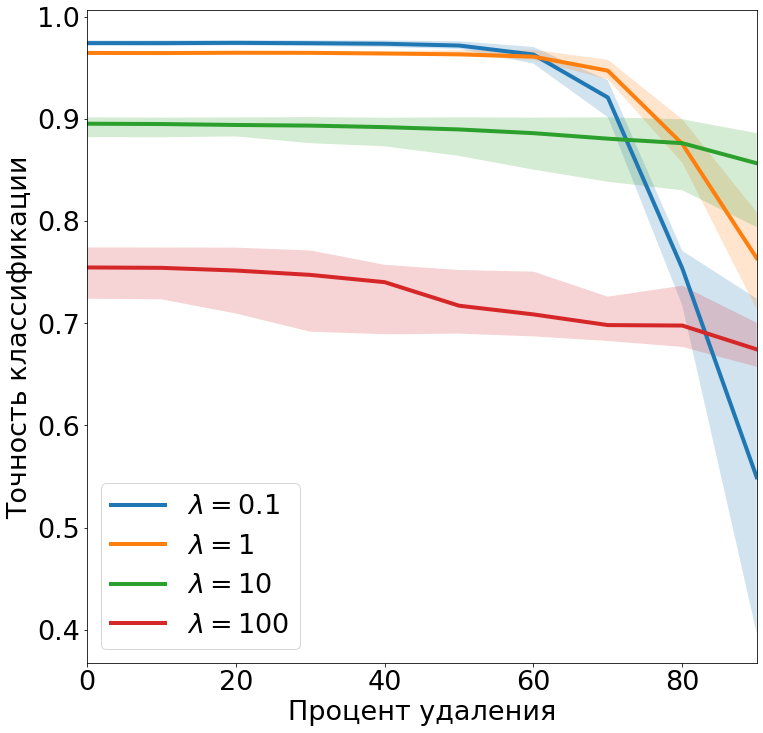

In [15]:
proc = [0,10,20,30,40,50,60,70,80,90]
ls = {
    '0.1':'-',
    '1':'--',
    '10':':',
    '100':'-.'
}
lamb = [0.1, 1,  10, 100]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
for lam in lamb:
    lam = str(lam)
    print(lam)
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
    #plt.errorbar(proc, np.mean(lam_results[lam], 0), 
     #                       yerr = np.std(lam_results[lam], 0), 
      #                      ls = ls[str(lam)],  elinewidth=0, ecolor='black', color=(0,0,0,0), lw=1)
    #plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam), ls = ls[str(lam)], c='k',
     #                  lw=2)
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('hypernets_var.eps', bbox_inches = 'tight')
plt.savefig('H_var_log_onestr')
plt.show()


In [16]:
def net_copy(net, new_net, lam):
    lam_param = lam/100.0
    for j in range(0, 2): # бежим по слоям        
        new_net[j].mean.data*=0
        new_net[j].mean.data+=net[j].mean(lam_param)
        new_net[j].mean_b.data*=0
        new_net[j].mean_b.data+=net[j].mean_b(lam_param)
        new_net[j].log_sigma.data*=0
        new_net[j].log_sigma.data+=net[j].log_sigma(lam_param)
        new_net[j].log_sigma_b.data*=0
        new_net[j].log_sigma_b.data+=net[j].log_sigma_b(lam_param)
    


In [17]:
hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
    
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))
        
        net_copy(hnet, net, lam)
        lam_results[lam].append(delete_10(net))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


0.1 0
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 1
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 2
no

nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
100 2
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
100 3
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero 

In [18]:
import json
with open('results_lowrank.json','w') as out:
    out.write(json.dumps(lam_results))

In [19]:
with open('results_lowrank.json') as inp:
        lam_results = json.loads(inp.read())

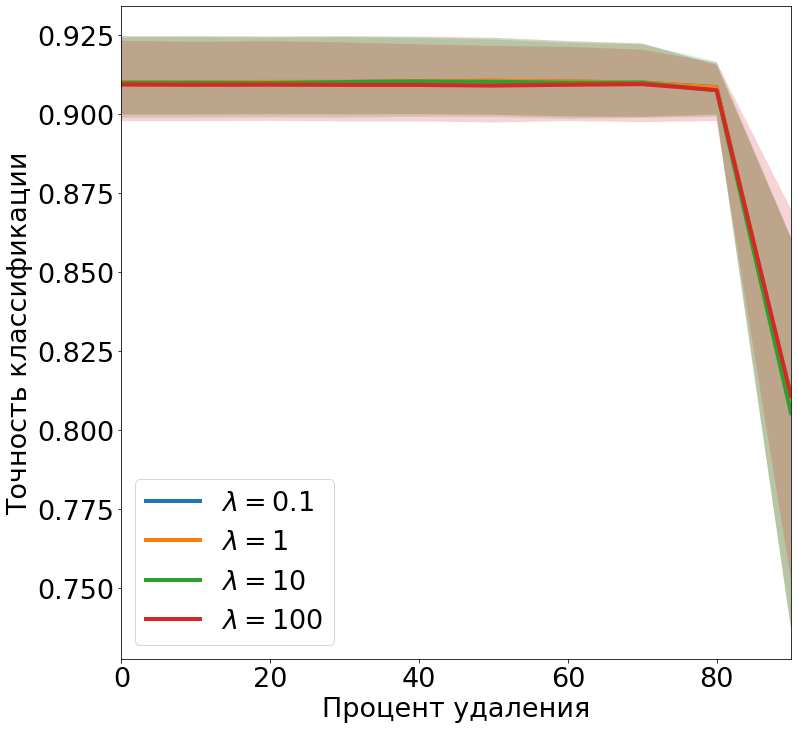

In [21]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = str(lam)
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('H_lowrank_log_onestr')
#plt.show()


In [23]:
hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
    
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))
        
        net_copy(hnet, net, lam)
        lam_results[lam].append(delete_10(net))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


0.1 0
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 1
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 2
no

nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
100 2
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
100 3
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero 

In [24]:
import json
with open('results_linear.json','w') as out:
    out.write(json.dumps(lam_results))

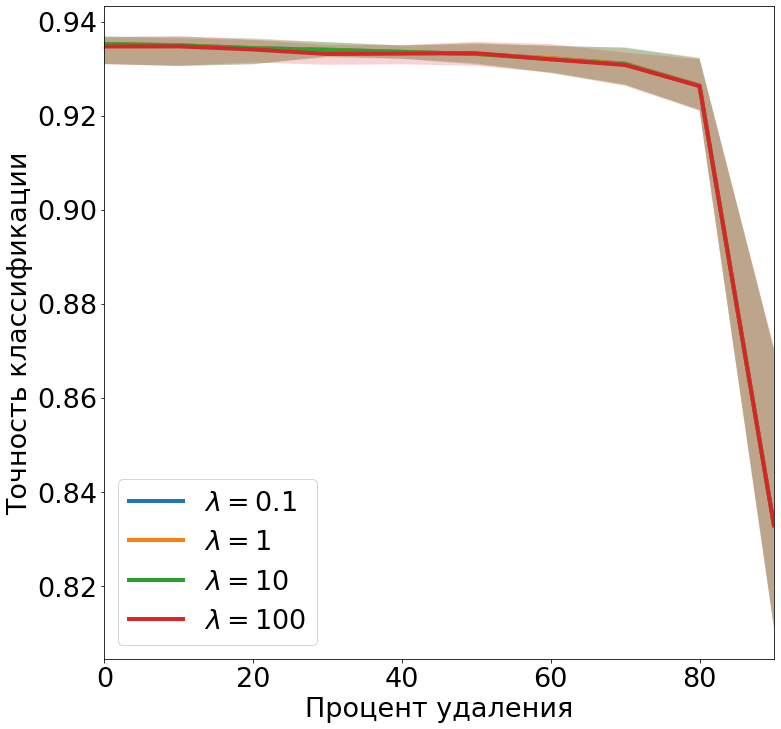

In [26]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    #lam = str(lam)
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('H_linear_log2')
#plt.show()


In [27]:
hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
    
lam_results = {}
t.manual_seed(0)
for lam in lamb:    
    lam_results[lam] = []
    for s in range(start_num):
        
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        label = 'finetune lowrank, lam:{} '.format(lam)                
        train_batches(net, loss_fn, optim, lam, label)        
        lam_results[lam].append(delete_10(net))
        

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
finetune lowrank, lam:0.1 0.3591548: 100%|██████████| 938/938 [00:16<00:00, 58.12it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:0.1 0.3823686: 100%|██████████| 938/938 [00:16<00:00, 58.49it/s] 


nonzero params:  tensor(0.8357, device='cuda:0')
nonzero params:  tensor(0.8357, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:0.1 0.36729074: 100%|██████████| 938/938 [00:14<00:00, 64.65it/s]


nonzero params:  tensor(0.8018, device='cuda:0')
nonzero params:  tensor(0.8018, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:0.1 0.3449618: 100%|██████████| 938/938 [00:13<00:00, 67.97it/s] 


nonzero params:  tensor(0.9542, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:0.1 0.32748377: 100%|██████████| 938/938 [00:13<00:00, 68.13it/s]


nonzero params:  tensor(0.9028, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:1 1.108064: 100%|██████████| 938/938 [00:13<00:00, 70.87it/s] 


nonzero params:  tensor(0.6263, device='cuda:0')
nonzero params:  tensor(0.6263, device='cuda:0')
nonzero params:  tensor(0.6263, device='cuda:0')
nonzero params:  tensor(0.6263, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:1 1.7197477: 100%|██████████| 938/938 [00:15<00:00, 61.07it/s]


nonzero params:  tensor(0.6543, device='cuda:0')
nonzero params:  tensor(0.6543, device='cuda:0')
nonzero params:  tensor(0.6543, device='cuda:0')
nonzero params:  tensor(0.6543, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:1 1.2055473: 100%|██████████| 938/938 [00:15<00:00, 62.47it/s]


nonzero params:  tensor(0.5478, device='cuda:0')
nonzero params:  tensor(0.5478, device='cuda:0')
nonzero params:  tensor(0.5478, device='cuda:0')
nonzero params:  tensor(0.5478, device='cuda:0')
nonzero params:  tensor(0.5478, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:1 1.2502928: 100%|██████████| 938/938 [00:15<00:00, 59.62it/s]


nonzero params:  tensor(0.7766, device='cuda:0')
nonzero params:  tensor(0.7766, device='cuda:0')
nonzero params:  tensor(0.7766, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:1 0.93095833: 100%|██████████| 938/938 [00:14<00:00, 62.93it/s]


nonzero params:  tensor(0.7300, device='cuda:0')
nonzero params:  tensor(0.7300, device='cuda:0')
nonzero params:  tensor(0.7300, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:10 5.641129: 100%|██████████| 938/938 [00:13<00:00, 67.08it/s] 


nonzero params:  tensor(0.4147, device='cuda:0')
nonzero params:  tensor(0.4147, device='cuda:0')
nonzero params:  tensor(0.4147, device='cuda:0')
nonzero params:  tensor(0.4147, device='cuda:0')
nonzero params:  tensor(0.4147, device='cuda:0')
nonzero params:  tensor(0.4147, device='cuda:0')
nonzero params:  tensor(0.3999, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:10 14.35087: 100%|██████████| 938/938 [00:13<00:00, 69.03it/s]  


nonzero params:  tensor(0.4932, device='cuda:0')
nonzero params:  tensor(0.4932, device='cuda:0')
nonzero params:  tensor(0.4932, device='cuda:0')
nonzero params:  tensor(0.4932, device='cuda:0')
nonzero params:  tensor(0.4932, device='cuda:0')
nonzero params:  tensor(0.4932, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:10 9.668151: 100%|██████████| 938/938 [00:14<00:00, 64.41it/s]  


nonzero params:  tensor(0.3585, device='cuda:0')
nonzero params:  tensor(0.3585, device='cuda:0')
nonzero params:  tensor(0.3585, device='cuda:0')
nonzero params:  tensor(0.3585, device='cuda:0')
nonzero params:  tensor(0.3585, device='cuda:0')
nonzero params:  tensor(0.3585, device='cuda:0')
nonzero params:  tensor(0.3585, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:10 7.973724: 100%|██████████| 938/938 [00:15<00:00, 60.99it/s]  


nonzero params:  tensor(0.7162, device='cuda:0')
nonzero params:  tensor(0.7162, device='cuda:0')
nonzero params:  tensor(0.7162, device='cuda:0')
nonzero params:  tensor(0.6999, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:10 5.192818: 100%|██████████| 938/938 [00:15<00:00, 59.55it/s] 


nonzero params:  tensor(0.6103, device='cuda:0')
nonzero params:  tensor(0.6103, device='cuda:0')
nonzero params:  tensor(0.6103, device='cuda:0')
nonzero params:  tensor(0.6103, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:100 15.768385: 100%|██████████| 938/938 [00:14<00:00, 65.03it/s] 


nonzero params:  tensor(0.9877, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:100 125.476555: 100%|██████████| 938/938 [00:15<00:00, 62.06it/s]


nonzero params:  tensor(0.9900, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:100 63.23837: 100%|██████████| 938/938 [00:13<00:00, 69.19it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:100 46.353638: 100%|██████████| 938/938 [00:13<00:00, 69.00it/s]


nonzero params:  tensor(0.9990, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:100 42.27721: 100%|██████████| 938/938 [00:14<00:00, 66.63it/s] 


nonzero params:  tensor(0.9900, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


In [28]:
import json
with open('results_lowrank_finetune.json','w') as out:
    out.write(json.dumps(lam_results))

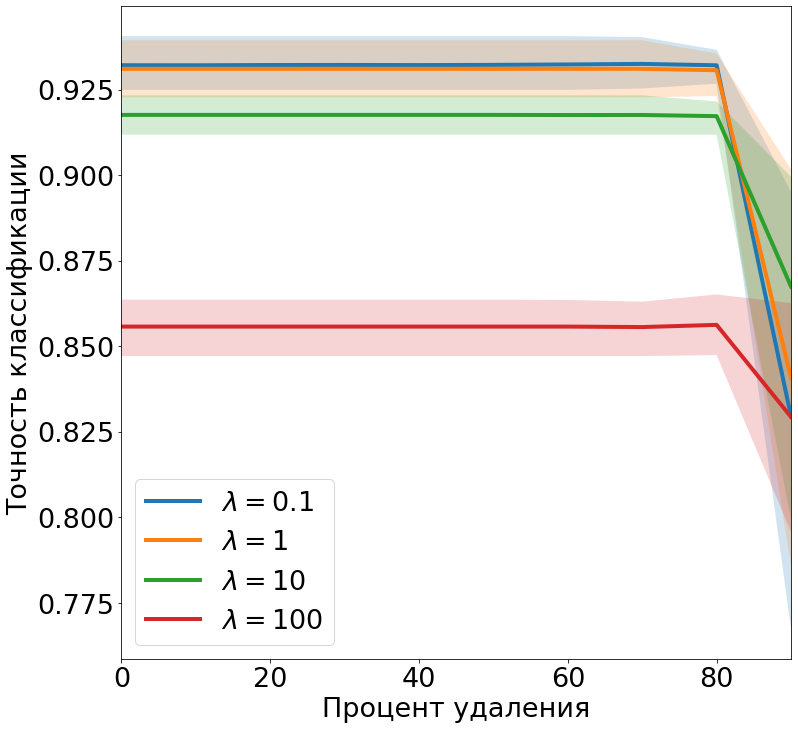

In [29]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('H_low_log+1')
#plt.show()


In [30]:
hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
t.manual_seed(0)    
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        label = 'finetune linear, lam:{} '.format(lam)                
        train_batches(net, loss_fn, optim, lam, label)        
        lam_results[lam].append(delete_10(net))
        

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
finetune linear, lam:0.1 0.3372445: 100%|██████████| 938/938 [00:15<00:00, 59.84it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:0.1 0.19438596: 100%|██████████| 938/938 [00:15<00:00, 59.90it/s]


nonzero params:  tensor(0.9976, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:0.1 0.19915804: 100%|██████████| 938/938 [00:15<00:00, 61.36it/s]


nonzero params:  tensor(0.9977, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:0.1 0.20091546: 100%|██████████| 938/938 [00:14<00:00, 64.22it/s]


nonzero params:  tensor(0.9992, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:0.1 0.20082596: 100%|██████████| 938/938 [00:13<00:00, 70.73it/s]


nonzero params:  tensor(0.9981, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:1 0.2561982: 100%|██████████| 938/938 [00:15<00:00, 60.47it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:1 0.2581202: 100%|██████████| 938/938 [00:15<00:00, 62.13it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.3994, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:1 0.26105192: 100%|██████████| 938/938 [00:15<00:00, 58.95it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:1 0.26258448: 100%|██████████| 938/938 [00:15<00:00, 62.11it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.3997, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:1 0.2613014: 100%|██████████| 938/938 [00:15<00:00, 60.03it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:10 0.6139946: 100%|██████████| 938/938 [00:13<00:00, 67.17it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:10 0.61951727: 100%|██████████| 938/938 [00:13<00:00, 68.31it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.6998, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:10 0.6195218: 100%|██████████| 938/938 [00:14<00:00, 63.55it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.3993, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:10 0.61790454: 100%|██████████| 938/938 [00:15<00:00, 61.59it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:10 0.6192683: 100%|██████████| 938/938 [00:15<00:00, 61.92it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.7999, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:100 2.2956336: 100%|██████████| 938/938 [00:15<00:00, 61.85it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:100 2.3174822: 100%|██████████| 938/938 [00:15<00:00, 61.66it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:100 2.3325865: 100%|██████████| 938/938 [00:15<00:00, 58.76it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:100 2.2836554: 100%|██████████| 938/938 [00:15<00:00, 59.34it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:100 2.3204167: 100%|██████████| 938/938 [00:14<00:00, 66.81it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.2999, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


In [31]:
import json
with open('results_linear_finetune.json','w') as out:
    out.write(json.dumps(lam_results))

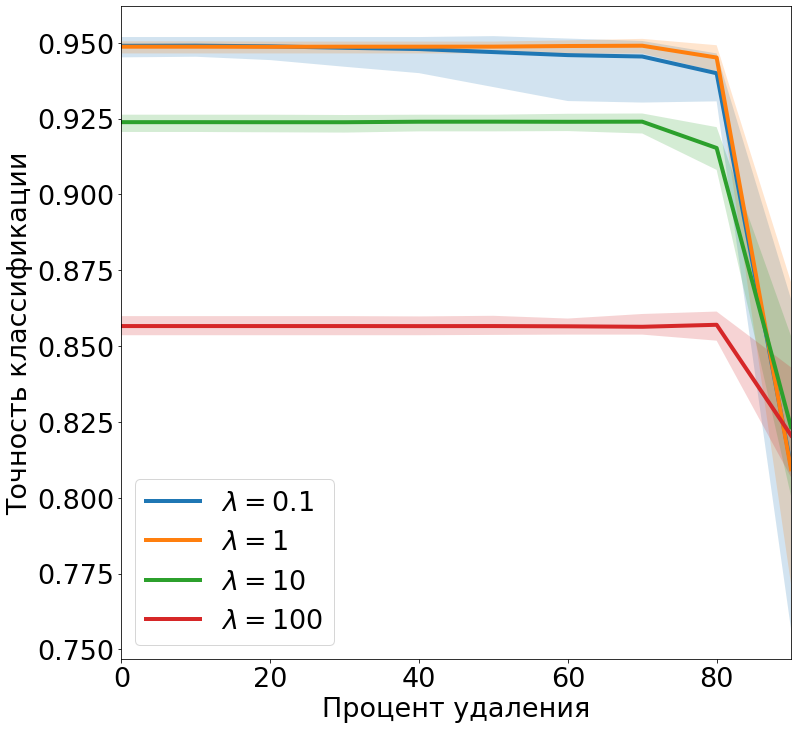

In [32]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Hypernet_linear + 1_log')
#plt.show()


In [33]:
for lam in lamb:
    t.manual_seed(0) 
    for start in range(start_num):                    
            net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)                        
            label = 'lambda {} '.format(lam)                
            train_batches(net, loss_fn, optim, lam, label)
            t.save(net.state_dict(), os.path.join(path_to_save, 'var_1e_net_lam_{}_start_{}.cpk'.format(lam, start)))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
lambda 100 38.138077: 100%|██████████| 938/938 [00:16<00:00, 55.22it/s]


In [34]:
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join('saved/', 'var_1e_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(delete_10(net))

0.1 0
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 1
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 2
no

nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
100 2
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
100 3
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero 

In [35]:
import json
with open('results_1e.json','w') as out:
    out.write(json.dumps(lam_results))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


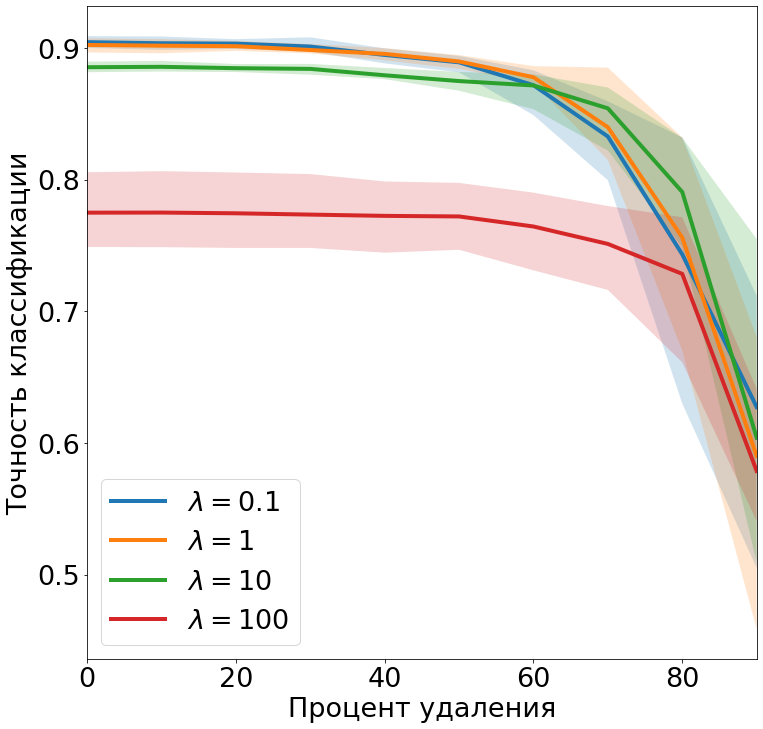

In [38]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('1e.eps', bbox_inches = 'tight')
#plt.show()


In [39]:
#calculating accuracy
for mode in ['results_var','results_1e', 'results_lowrank', 'results_linear', 'results_lowrank_finetune', 'results_linear_finetune']:
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        data = json.loads(inp.read())
    for lam in lamb:
        lam = str(lam)
        print (lam, np.mean(data[lam][0]), np.std(data[lam][0]))
    print()

mode: results_var
0.1 0.9077399999999999 0.12631355588376095
1 0.92608 0.07683372696934597
10 0.8997100000000001 0.004544106072705608
100 0.7187300000000001 0.03233045158979379

mode: results_1e
0.1 0.85395 0.07014032007340712
1 0.84863 0.07960891972637238
10 0.8274100000000001 0.10110299154822275
100 0.7151099999999999 0.05878645167043169

mode: results_lowrank
0.1 0.8943399999999999 0.0452468606645809
1 0.89467 0.044323471208830185
10 0.89212 0.05161088644850039
100 0.89374 0.04701338532801056

mode: results_linear
0.1 0.92397 0.02951603123727849
1 0.92391 0.02952932271488799
10 0.9238299999999999 0.029543427357028158
100 0.92136 0.029592505808058903

mode: results_lowrank_finetune
0.1 0.91644 0.04971929605294106
1 0.91923 0.04404334342440409
10 0.91402 0.018873356882123528
100 0.8583400000000001 0.016054606815490684

mode: results_linear_finetune
0.1 0.92821 0.030659173178675263
1 0.9369099999999999 0.04023852507237311
10 0.9175800000000001 0.02385308365809336
100 0.85473 0.01598662

In [80]:
#calculating stability
for mode in ['results_var','results_1e', 'results_lowrank', 'results_linear', 'results_lowrank_finetune', 'results_linear_finetune']:
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        data = json.loads(inp.read())
        
    for lam in lamb:
        lam = str(lam)
        v_0 = np.array(data[lam])[:,0]
        v_last = np.array(data[lam])[:,-1]
        
        stab = v_0/v_last
        print (lam, np.mean(stab), np.std(stab))
    print()

mode: results_var
0.1 2.2095718406753138 0.2540762518381766
1 1.4768410313948264 0.03876415389661146
10 1.1943260860289477 0.05432335063576823
100 1.1655268629230346 0.041839688354412444

mode: results_1e
0.1 1.5185162146863513 0.12024690253702998
1 1.5372498646770185 0.11219062902901537
10 1.4739058696158518 0.15075498492006287
100 1.3628170603874603 0.12360810190146203

mode: results_lowrank
0.1 1.2080033648003554 0.036392145931447024
1 1.2039375357495192 0.03583030769565768
10 1.1771149074472835 0.0411980956603168
100 1.125795823134514 0.014758241950911407

mode: results_linear
0.1 1.206345194353315 0.04059851352997449
1 1.2054338775292013 0.039321262550000124
10 1.2084818282443863 0.05476608902095843
100 1.216403821971243 0.061170985544500525

mode: results_lowrank_finetune
0.1 1.2026498344131247 0.04651840951491279
1 1.2017604983236403 0.038063595869942624
10 1.1860341711973903 0.04623328301384698
100 1.1563848700493828 0.07275206194967425

mode: results_linear_finetune
0.1 1.2811

In [87]:
print ('ordinal model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):        
        net.load_state_dict(t.load(os.path.join('saved/', 'var_net_lam_{}_start_{}.cpk'.format(lam, s))))                 
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
        

ordinal model


<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


0.1 9035.229504442215
1 24338.233991146088
10 56679.427070617676
100 128928.67107391357


In [90]:
print ('1e model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):        
        net.load_state_dict(t.load(os.path.join('saved/', 'var_1e_net_lam_{}_start_{}.cpk'.format(lam, s))))                 
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
        

1e model


<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


0.1 32788.8383392334
1 51832.86357688904
10 186124.63739395142
100 696240.5514717102


In [92]:
print ('lr model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
print ('lr ft model')
for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)        
        train_batches(net, loss_fn, optim, lam, label)   
        
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]  
        
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
                

lr model


<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
<ipython-input-11-cd1a223d91d2>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
<ipython-input-11-cd1a223d91d2>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-11-cd1a223d91d2>:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.i

0.1 24566.31489696503
1 30949.930117607117
10 56720.93189239502


lambda 100 0.4310196:   1%|          | 9/938 [00:00<00:10, 88.79it/s] 

100 166657.0206642151
lr ft model


lambda 100 0.5384838:   1%|          | 10/938 [00:00<00:10, 92.33it/s] 

0.1 19994.676700782777


lambda 100 0.98274064:   1%|          | 9/938 [00:00<00:10, 89.95it/s]

1 27220.746832847595


lambda 100 2.7311857:   1%|          | 10/938 [00:00<00:10, 91.06it/s]

10 55508.39735031128


lambda 100 2.3467298: 100%|██████████| 938/938 [00:10<00:00, 89.02it/s]


100 132758.4135055542


In [93]:
print ('linear model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
print ('lr ft model')
for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)        
        train_batches(net, loss_fn, optim, lam, label)   
        
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]  
        
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
                

linear model


<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
<ipython-input-11-cd1a223d91d2>:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-11-cd1a223d91d2>:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  gain_const2)


0.1 24603.766856002807
1 28189.602142333984
10 58147.424964904785


lambda 100 0.47204697:   1%|          | 10/938 [00:00<00:09, 94.41it/s]

100 177139.47687149048
lr ft model


lambda 100 0.53265625:   1%|          | 10/938 [00:00<00:10, 92.13it/s]

0.1 20776.47305698395


lambda 100 1.0129691:   1%|          | 9/938 [00:00<00:10, 88.86it/s]

1 26262.995717048645


lambda 100 2.8632925:   1%|          | 10/938 [00:00<00:10, 92.44it/s]

10 57948.82610321045


lambda 100 2.3490837: 100%|██████████| 938/938 [00:10<00:00, 92.32it/s]


100 134340.96174240112


In [112]:
# количество оптимизаций параметров
# количество батчей * количество эпох * количество параметров, домноженное на количество элементов в lamb
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
p_num = 0
for p in hnet.parameters():
    size = p.size()
    if len(size)==1:
        p_num += size[0]
    elif len(size) == 2:
        p_num += np.prod(size)    
p_num_var = p_num
print ('ordinal', len(train_loader)*epoch_num*(p_num)*len(lamb))
print ('1e', len(train_loader)*p_num * len(lamb))

hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
p_num = 0
for p in hnet.parameters():
    size = p.size()
    if len(size)==1:
        p_num += size[0]
    elif len(size) == 2:
        p_num += np.prod(size)    
    
print ('low rank', len(train_loader)*epoch_num*(p_num))
print ('low rank finetune', len(train_loader)*epoch_num*(p_num) + len(train_loader)*p_num_var)

hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
p_num = 0
for p in hnet.parameters():
    size = p.size()
    if len(size)==1:
        p_num += size[0]
    elif len(size) == 2:
        p_num += np.prod(size)    
    
print ('linear', len(train_loader)*epoch_num*(p_num))
print ('linear fine tune', len(train_loader)*epoch_num*(p_num) + len(train_loader)*p_num_var)

ordinal 14917952000
1e 596718080
low rank 4165376600
low rank finetune 4314556120
linear 3729488000
linear fine tune 3878667520


<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
<ipython-input-11-cd1a223d91d2>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
<ipython-input-11-cd1a223d91d2>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-11-cd1a223d91d2>:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.i

In [25]:
#new plots
for mode in ['results_var','results_1e', 'results_lowrank', 'results_linear', 'results_lowrank_finetune', 'results_linear_finetune']:
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        data = json.loads(inp.read())
    for lam in lamb:
        lam = str(lam)
        print (lam, np.mean(data[lam][0]), np.std(data[lam][0]))
    print()

mode: results_var
0.1 0.8768600000000001 0.180850502902259
1 0.9015699999999999 0.1015020103249192
10 0.8674 0.061154280308086374
100 0.73031 0.037807312784698156

mode: results_1e


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

mode: results_var
mode: results_1e
mode: results_lowrank
mode: results_lowrank_finetune
mode: results_linear
mode: results_linear_finetune


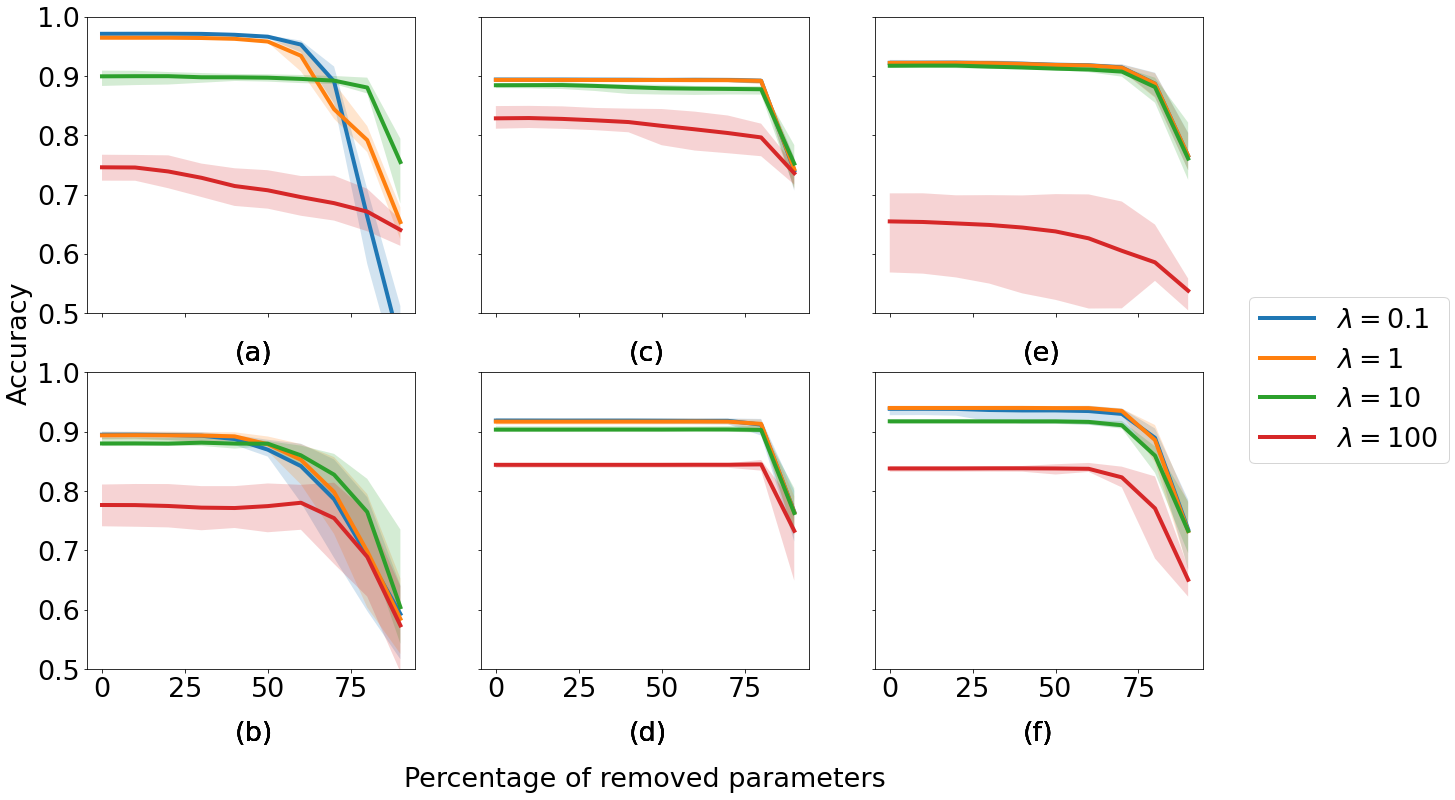

In [44]:
plt.rcParams['figure.figsize'] = 20, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
fig, axs = plt.subplots(2, 3)
coords = [(0,0), (1,0), (0,1), (1,1), (0,2), (1,2)]
titles = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
ls = {
    '0.1':'-',
    '1':'--',
    '10':':',
    '100':'-.'
}
roc = np.array([0,10,20,30,40,50,60,70,80,90])
for id, mode in enumerate(['results_var','results_1e', 'results_lowrank', 'results_lowrank_finetune', 'results_linear', 'results_linear_finetune']):
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        lam_results = json.loads(inp.read())
    current_ax = axs[coords[id][0], coords[id][1]]


    for lam in lamb:
        lam = str(lam)
        current_ax.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
        current_ax.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
        
        # вызываем plot и errorbar два раза:
        # (здесь это оказалось ненужным, но оставил на случай переделок:
        # если ошибки разных графиков сильно накладываются, их разносят небольшим сдвигом
        # а сами линии средних значений оставляют на месте)
       # current_ax.errorbar(proc, np.mean(lam_results[lam], 0), 
        #                    yerr = np.std(lam_results[lam], 0), 
         #                   ls = ls[lam],  elinewidth=0)#, ecolor='black', color=(0,0,0,0), lw=1)
        #current_ax.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam), ls = ls[lam], c='k',
         #              lw=2)
        
        #current_ax.set_title(titles[id], y=-0.05)
        if id in [1,3,5]:
            current_ax.text(40, .38, titles[id])
        else:
            current_ax.text(40, .42, titles[id])
        current_ax.set_ylim((0.5, 1.0))
        if id != 0 and id != 1:
            current_ax.set_yticklabels([])
        if id not in [1,3,5]:
            current_ax.set_xticklabels([])
        if id == 5:
            current_ax.legend(bbox_to_anchor=(1.1, 1.3))
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.ylabel('Accuracy', fontsize = 27)
plt.xlabel('Percentage of removed parameters', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
ax = plt.gca() 
ax.xaxis.set_label_coords(0.5, -0.15) 
#plt.autoscale(enable=True, axis='x', tight=False)
#fig.tight_layout()
plt.savefig('hypernets_colour_begin.png', bbox_inches = 'tight')
#plt.show()



mode: results_var
mode: results_1e
mode: results_lowrank
mode: results_lowrank_finetune
mode: results_linear
mode: results_linear_finetune


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


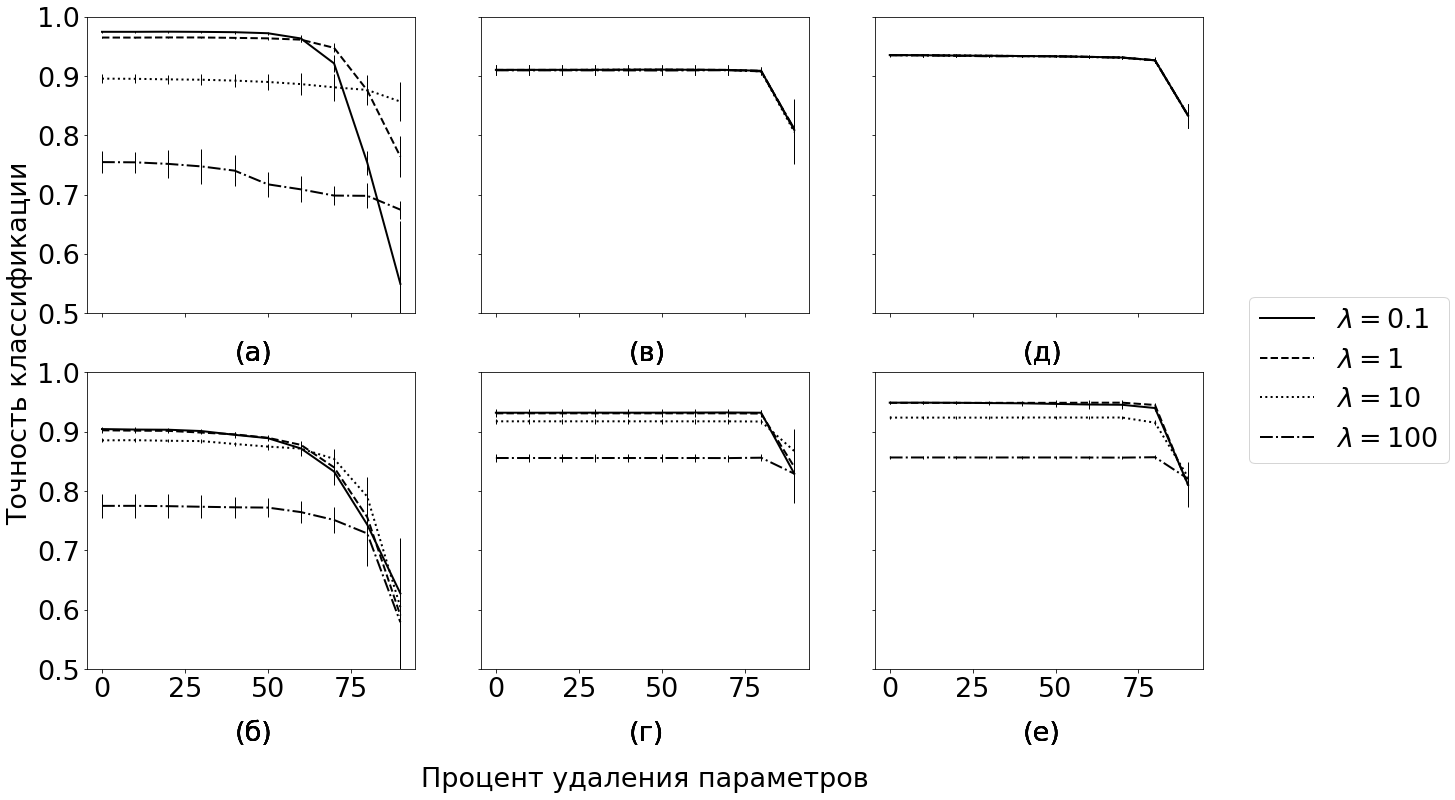

In [42]:
plt.rcParams['figure.figsize'] = 20, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
fig, axs = plt.subplots(2, 3)
coords = [(0,0), (1,0), (0,1), (1,1), (0,2), (1,2)]
titles = ['(а)', '(б)', '(в)', '(г)', '(д)', '(е)']
ls = {
    '0.1':'-',
    '1':'--',
    '10':':',
    '100':'-.'
}
roc = np.array([0,10,20,30,40,50,60,70,80,90])
for id, mode in enumerate(['results_var','results_1e', 'results_lowrank', 'results_lowrank_finetune', 'results_linear', 'results_linear_finetune']):
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        lam_results = json.loads(inp.read())
    current_ax = axs[coords[id][0], coords[id][1]]

    for lam in lamb:
        lam = str(lam)
        
        # вызываем plot и errorbar два раза:
        # (здесь это оказалось ненужным, но оставил на случай переделок:
        # если ошибки разных графиков сильно накладываются, их разносят небольшим сдвигом
        # а сами линии средних значений оставляют на месте)
        current_ax.errorbar(proc, np.mean(lam_results[lam], 0), 
                            yerr = np.std(lam_results[lam], 0), 
                            ls = ls[lam],  elinewidth=0, ecolor='black', color=(0,0,0,0), lw=1)
        current_ax.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam), ls = ls[lam], c='k',
                       lw=2)
        
        #current_ax.set_title(titles[id], y=-0.05)
        if id in [1,3,5]:
            current_ax.text(40, .38, titles[id])
        else:
            current_ax.text(40, .42, titles[id])
        current_ax.set_ylim((0.5, 1.0))
        if id != 0 and id != 1:
            current_ax.set_yticklabels([])
        if id not in [1,3,5]:
            current_ax.set_xticklabels([])
        if id == 5:
            current_ax.legend(bbox_to_anchor=(1.1, 1.3))
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления параметров', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
ax = plt.gca() 
ax.xaxis.set_label_coords(0.5, -0.15) 
#plt.autoscale(enable=True, axis='x', tight=False)
#fig.tight_layout()
plt.savefig('hypernets.eps', bbox_inches = 'tight')
#plt.show()

<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, **kwargs)>